In [81]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from dataloader import CustomImageDataset

In [109]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to 224x224
    transforms.ToTensor()
])

# Create the dataset and dataloader

class_to_idx = {'sma': 1, 'non-sma': 0}

# Get current directory
current_directory = os.getcwd()

# Relative directory of images
other_string = "Red_Cell_Morphology 3/"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

# Create dataset
dataset = CustomImageDataset(root_dir=new_path, class_to_idx=class_to_idx, transform=transform)

# Create data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [112]:
# Get counts
counts = dataset.get_class_counts()
print(counts)

{'sma': 33, 'non-sma': 33}


Class: non-SMA, Number of images: 10


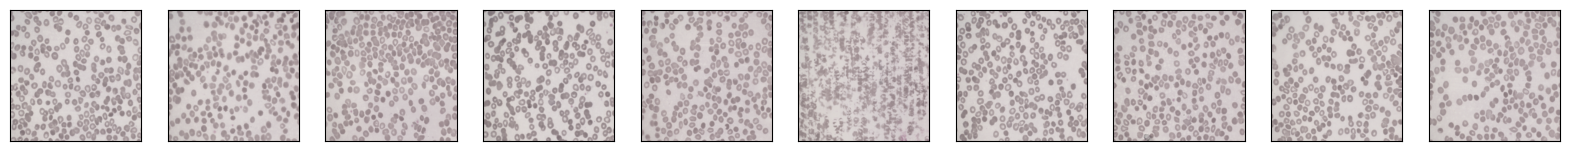

In [110]:
# Fetch first bag from the DataLoader
images, label = next(iter(data_loader))

print(f"Class: {'SMA' if label.item()==1 else 'non-SMA'}, Number of images: {len(images)}")

# Display all images from this bag
fig = plt.figure(figsize=(20, 10))  # adjust size as needed
for i in range(len(images)):
    ax = fig.add_subplot(1, len(images), i+1, xticks=[], yticks=[])
    img = images[i].squeeze().permute(1, 2, 0)  
    ax.imshow(img.numpy())
plt.show()

In [111]:
# Iterate through the data loader
for images, label in data_loader:
    # Iterate through each image in the bag
    for i in range(len(images)):
        print(f"Image {i+1} dimensions: {images[i].size()}")

Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions: torch.Size([1, 3, 224, 224])
Image 4 dimensions: torch.Size([1, 3, 224, 224])
Image 5 dimensions: torch.Size([1, 3, 224, 224])
Image 1 dimensions: torch.Size([1, 3, 224, 224])
Image 2 dimensions: torch.Size([1, 3, 224, 224])
Image 3 dimensions: torch.Size([1, 3, 224, 224])
Image 4 dimensions: torch.Size([1, 3, 224, 224])
Image 5 dimensions: torch.Size([1, 3, 224, 224])
Image 6 dimensions: torch.Size([1, 3, 224, 224])
Image 7 dimensions: torch.Size([1, 3, 224, 224])
Image 8 dimensions: torch.Size([1, 3, 224, 224])
Image 9 dimensions: torch.Size([1, 3, 224, 224])
Image 10 dimensions: torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [120]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 500)  # Adjusted for input image size 224x224
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Perform individual feature extraction on each image
        features = []
        for img in x:
            img_features = self.pool(F.relu(self.conv1(img)))
            img_features = self.pool(F.relu(self.conv2(img_features)))            
            img_features = img_features.view(img_features.size(0), -1)  # Flatten layer
            img_features = F.relu(self.fc1(img_features))
            img_features = self.fc2(img_features)
            features.append(img_features)

        # Apply max pooling across all images
        pooled_features = torch.stack(features)
        print(pooled_features.size())
        pooled_features, _ = torch.max(pooled_features, dim=0)
        print(pooled_features.size())

        # Flatten the pooled features
        x = pooled_features.view(pooled_features.size(0), -1)

        # Pass through the fully connected layers
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid activation

        return x

In [121]:
# Initialize the network and optimizer
net = SimpleCNN()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

# Function to perform max pooling over feature vectors
def max_pool_feature_vectors(feature_vectors):
    return torch.max(feature_vectors, 0)[0]

# Calculate class frequencies
class_0_count = 110  # Number of samples in class 0
class_1_count = 33  # Number of samples in class 1

# Calculate class weights
total_count = class_0_count + class_1_count
class_0_weight = total_count / (2 * class_0_count)
class_1_weight = total_count / (2 * class_1_count)

weight=torch.tensor([class_1_weight])
print(weight)
                    
# Training loop
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0

    with tqdm(total=len(data_loader),desc=f'Epoch {epoch+1}/{1}', unit='batch') as pbar:
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(len(inputs))
            # print(inputs[0].size()) # Len n images of size [1,3,224,224]
            # print(labels) # Tensor scalar
            
            target = net(inputs)
            print('actual label: ', labels)

            print('target: ', target)

            loss = F.binary_cross_entropy_with_logits(target[0],labels.float(),weight=weight)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            # pbar.set_postfix({'loss': running_loss})            
            running_loss = 0.0

             # Print loss in every minibatch
            print(f'Epoch {epoch+1}/{1}, Minibatch {i+1}/{len(data_loader)}, Loss: {loss.item()}')
            pbar.update(1)

print('Finished Training')

tensor([2.1667])


Epoch 1/1:   0%|          | 0/66 [00:00<?, ?batch/s]

torch.Size([10, 1, 100])
torch.Size([1, 100])
actual label:  tensor([1])
target:  tensor([[0.4858]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   2%|▏         | 1/66 [00:04<05:10,  4.78s/batch]

Epoch 1/1, Minibatch 1/66, Loss: 1.0388575792312622
torch.Size([6, 1, 100])
torch.Size([1, 100])
actual label:  tensor([0])
target:  tensor([[0.4858]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   3%|▎         | 2/66 [00:07<03:31,  3.30s/batch]

Epoch 1/1, Minibatch 2/66, Loss: 2.0914359092712402
torch.Size([10, 1, 100])
torch.Size([1, 100])
actual label:  tensor([0])
target:  tensor([[0.4857]], grad_fn=<SigmoidBackward0>)


Epoch 1/1:   3%|▎         | 2/66 [00:10<05:49,  5.46s/batch]


KeyboardInterrupt: 